<a href="https://colab.research.google.com/github/praveenkumarbalakrishnan/tasks/blob/main/SIG731_Data_Wrangling_Task8HD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Title:** Task 8HD: SIG731-Data Wrangling

**Name:** Praveenkumar Balakrishnan

**Student Number:** 223029369

**Email Address:** s223029369@deakin.edu.au


# Import statements

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import argparse
import re
import os
import time
import xml.etree.cElementTree as cetree

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

# Tasks

Selected Movies & TV dataset for this analysis

**Task 1**

Convert all the data tables (Badges, Comments, PostHistory, PostLinks, Posts, Tags, Users, Votes)
from XML to CSV, using custom code that you write yourself. Ideally, you should write a Python
function that takes a single input file name (.xml) and output file name (.csv) and performs the
conversion of a single dataset.

**Task 2**

Load the CSV files as pandas data frames


Column names for 8 dataset based on the schema documentation

In [4]:
file_path = '/content/drive/MyDrive/Inputs/'

badges_cols = ['Id', 'UserId', 'Name', 'Date', 'Class', 'TagBased']
comments_cols = [
    'Id', 'PostId', 'Score', 'Text', 'CreationDate', 'UserDisplayName',
    'UserId', 'ContentLicense']
post_history_cols = [
    'Id', 'PostHistoryTypeId', 'PostId', 'RevisionGUID', 'CreationDate',
    'UserId', 'UserDisplayName', 'Comment', 'Text', 'ContentLicense']
post_links_cols = [
    'Id', 'CreationDate', 'PostId', 'RelatedPostId', 'LinkTypeId']
posts_cols = [
    'Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
    'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
    'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
    'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
    'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
    'ContentLicense']
tags_cols = [
    'Id', 'TagName', 'Count', 'ExcerptPostId', 'WikiPostId',
    'IsModeratorOnly', 'IsRequired']
users_cols = [
    'Id', 'Reputation', 'CreationDate', 'DisplayName', 'LastAccessDate',
    'WebsiteUrl', 'Location', 'AboutMe', 'Views', 'UpVotes', 'DownVotes',
    'ProfileImageUrl', 'AccountId']
votes_cols = [
    'Id', 'PostId', 'VoteTypeId', 'UserId',  'CreationDate', 'BountyAmount']

meta_dict = {
    'Badges': badges_cols, 'Comments': comments_cols,
    'PostHistory': post_history_cols, 'PostLinks': post_links_cols,
    'Posts': posts_cols, 'Tags': tags_cols, 'Users': users_cols,
    'Votes': votes_cols}

Parsed the xml elements, iterated in a loop and applied the regex functions to remove extra tags and other characters then load it in a csv file

In [5]:
def get_data(xml_file_name, cols_list):
    """
    This generator is to parse the xml data and yield as a row

    Parameters
    ----------
    file_name: str
      Input xml file name
    cols: list
      Column names of the input files
    
    Yield
    ------
    row: str
      Row from xml data
    """
    col_names = ''
    for col in cols_list:
      col_names = col_names + col + '|'
    col_names = col_names[:-1] + '\n'
    yield col_names

    for event, elem in cetree.iterparse(xml_file_name):
      row = ''
      if elem.tag == "row":
        for col in cols_list:
          if col in elem.attrib:
              val = elem.attrib[col].replace("|", " ").replace('\n', ' ')
              if col in ['Tags']:
                val = re.sub(r'<', '', val)
                val = re.sub(r'>', ' ', val)
              else:
                val = re.sub(r'<.?>', '', val)
                val = re.sub(r'\'t', 't', val)
                val = re.sub(r'\'s', 's', val)
                val = re.sub('[^A-Za-z0-9-:.]+', ' ', val)
                val = re.sub(' +', ' ', val)
              row = row + val.rstrip(' p') + '|'
          else:
              row = row + '|'
        row = row[:-1] + '\n'
        yield row
        elem.clear()

def convert_xml_to_csv(file_name, cols_list, path):
  """
  This function is to convert xml to csv and write as csv file
  and upper value

  Parameters
  ----------
  file_name: str
    Input filename without the extension like ".xml"
  cols: list
    Column names of the input files
  
  Return
  ------
  csv_filename: str
    Output csv filename
  """
  xml_file_name = os.path.join(path, file_name + '.xml')
  output_file_name = os.path.join(path, file_name + '.csv')

  data = get_data(xml_file_name, cols_list)
  with open(output_file_name, 'w') as f:
      for item in data:
          f.write(item)
  return output_file_name

Invoked xml conversion function and got the filename then used pandas read_csv to load the data into separate dataframes.

Note: Used dictionary to store the dataframe in the loop

In [6]:
data_dict = {}
for k, v in meta_dict.items():
  csv_file_name = convert_xml_to_csv(k, v, file_path)
  data_dict[k] = pd.read_csv(csv_file_name, delimiter='|')

Loaded as pandas dataframe for the further analysis

In [7]:
badges_df = data_dict['Badges']
comments_df = data_dict['Comments']
post_history_df = data_dict['PostHistory']
post_links_df = data_dict['PostLinks']
posts_df = data_dict['Posts']
tags_df = data_dict['Tags']
users_df = data_dict['Users']
votes_df = data_dict['Votes']

**Task 3**

Create at least five nontrivial data visualisations and/or tables, at least three of which are based
on the extraction of information from text (e.g., tags, keywords, locations, etc.).

**Plot to explore top 10 tags on the post**

In [8]:
tags_count_map = pd.Series(
    ' '.join(posts_df['Tags'].dropna().astype(str)).lower().split()
    ).value_counts()
top_10_tags_count_map = tags_count_map[:10]
top_10_tags_count_map

plot-explanation             8091
character                    2336
analysis                     1366
marvel-cinematic-universe    1322
dialogue                      916
identify-this-movie           861
game-of-thrones               797
production                    682
film-techniques               540
realism                       487
dtype: int64

Plot explanation, character discussion, movie analysis & Marvel Cinematic Universe related posts are high compared to others

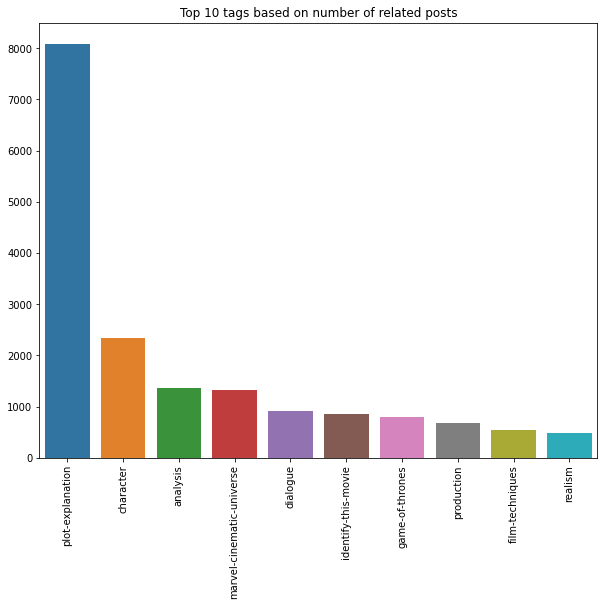

In [9]:
plt.figure(figsize=(10,8))
plt.title("Top 10 tags based on number of related posts")
plot = sns.barplot(
    x=list(top_10_tags_count_map.index), y=top_10_tags_count_map.values)
plt.xticks(rotation=90)
plt.show()


In [10]:
top_10_tags_count_map

plot-explanation             8091
character                    2336
analysis                     1366
marvel-cinematic-universe    1322
dialogue                      916
identify-this-movie           861
game-of-thrones               797
production                    682
film-techniques               540
realism                       487
dtype: int64

In this analysis took top 4 tags which is Plot explanation, character discussion, movie analysis & Marvel Cinematic Universe and analyzed most important keywords to tag the titles. Which can be used to built the model to tag the posts based on the title.

**Wordcloud to view most used words in the question title**

Title column is available only for the questions dropping na in that column keeps only the questions from the post in all the below analysis

movie, character, scene, film, end, know..... are more frequently used words overall

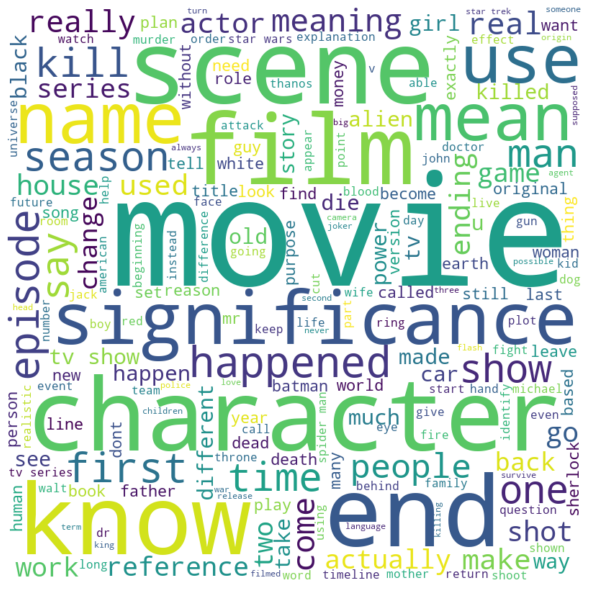

In [11]:
wc_df = posts_df.dropna(subset=['Title']) 
stopwords = set(
    list(STOPWORDS) + ['didnt', 'doesnt', 'whats', 'will', 'wasnt', 's'])
words = ' '.join(wc_df['Title'].astype(str)).lower()
wordcloud = WordCloud(
    stopwords=stopwords, min_font_size=10, background_color='white',
    width=800, height=800).generate(words)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Created a list of tags and exploded to filter the tags that we are interested in analysis

In [12]:
posts_df['TagsNew'] = posts_df.dropna(subset=['Title'])['Tags'].apply(
    lambda x : x.split(' '))
exploded_posts_df = posts_df.explode('TagsNew')

Words like know, movie, end, happened, kill, character, scene, etc will be helpful to tag the questions as plot explaination

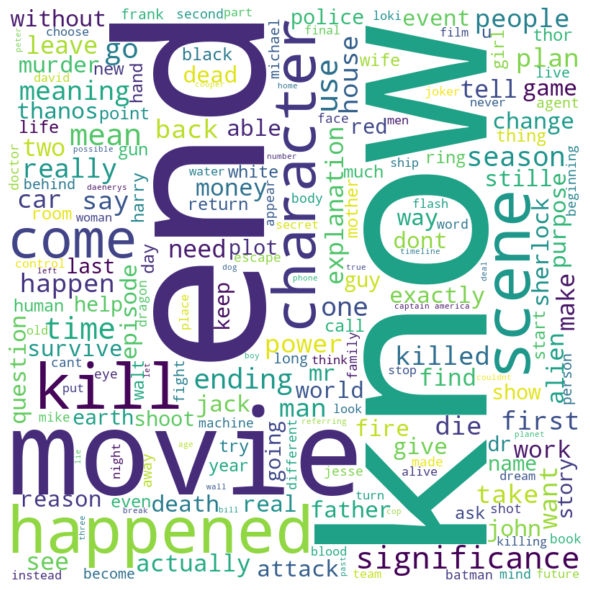

In [13]:
pe_df = exploded_posts_df.query("TagsNew=='plot-explanation'")
stopwords = set(
    list(STOPWORDS) + ['didnt', 'doesnt', 'whats', 'will', 'wasnt', 's'])
words = ' '.join(pe_df['Title'].astype(str)).lower()
wordcloud = WordCloud(
    stopwords=stopwords, min_font_size=10, background_color='white',
    width=800, height=800).generate(words)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Words like Character, movie, happened, name, end, significance, power, character names in the films, etc.. will help to tag the questions as character analysis

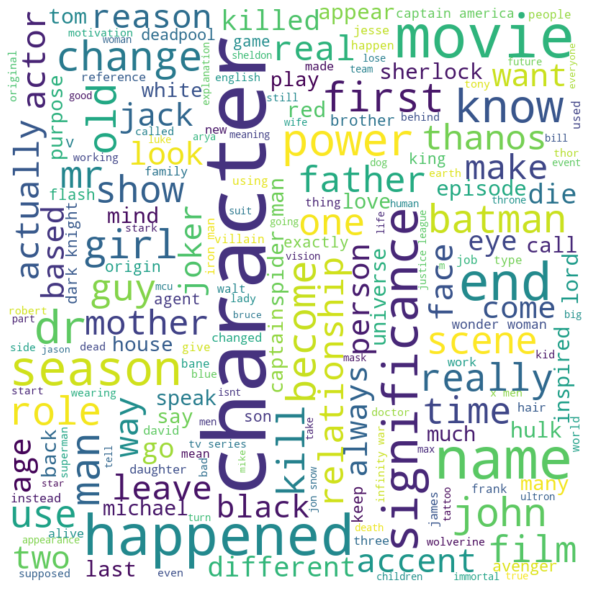

In [14]:
ce_df = exploded_posts_df.query("TagsNew=='character'")
stopwords = set(
    list(STOPWORDS) + ['didnt', 'doesnt', 'whats', 'will', 'wasnt', 's'])
words = ' '.join(ce_df['Title'].astype(str)).lower()
wordcloud = WordCloud(
    stopwords=stopwords, min_font_size=10, background_color='white',
    width=800, height=800).generate(words)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Words like significance, meaning, movie, character, scene, ending etc.. will help to tag the questions to movie analysis

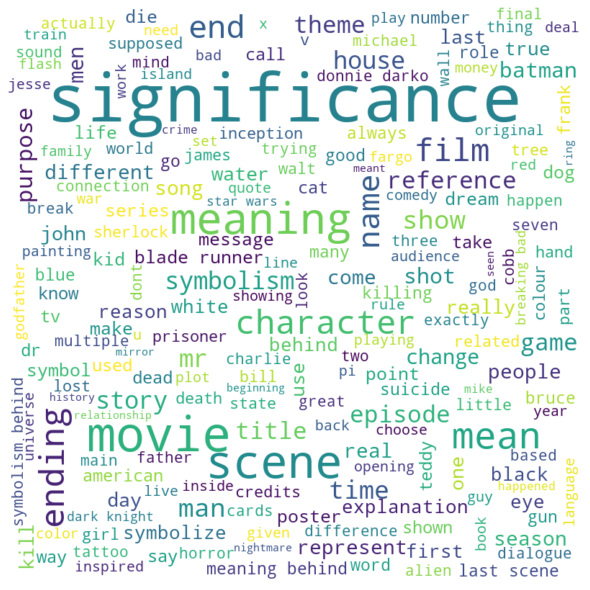

In [15]:
a_df = exploded_posts_df.query("TagsNew=='analysis'")
stopwords = set(
    list(STOPWORDS) + ['didnt', 'doesnt', 'whats', 'will', 'wasnt', 's'])
words = ' '.join(a_df['Title'].astype(str)).lower()
wordcloud = WordCloud(
    stopwords=stopwords, min_font_size=10, background_color='white',
    width=800, height=800).generate(words)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Character names and objects used in the films are the words which will help to tag the questions to marvel-cinematic-universe

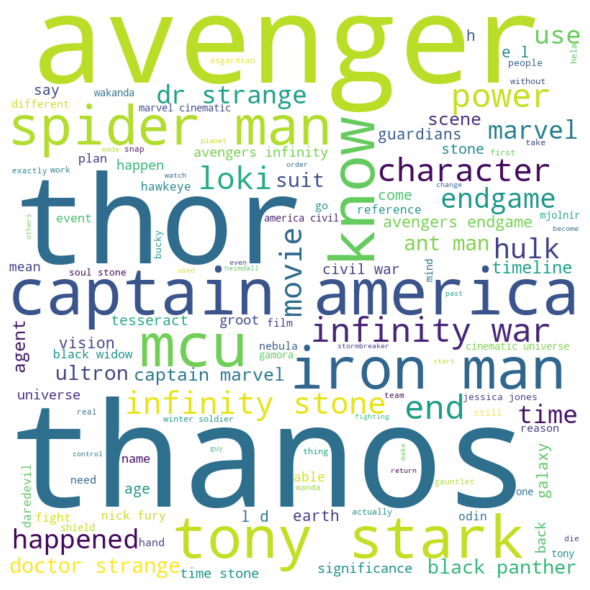

In [16]:
m_df = exploded_posts_df.query("TagsNew=='marvel-cinematic-universe'")
stopwords = set(
    list(STOPWORDS) + ['didnt', 'doesnt', 'whats', 'will', 'wasnt', 's'])
words = ' '.join(m_df['Title'].astype(str)).lower()
wordcloud = WordCloud(
    stopwords=stopwords, min_font_size=10, background_color='white',
    width=800, height=800).generate(words)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**No of questions answered**

In this analysis we explore on the number of questions answered and in which day of week more questions answered

Filtered questions and asnwers data from the posts

In [17]:
qs_df = posts_df.query("PostTypeId==1")[
    ['Id', 'CreationDate']].rename(columns={
    'CreationDate': 'QuesCreationDate'})
as_df = posts_df.query("PostTypeId==2")[
    ['ParentId', 'CreationDate']].rename(columns={
        'ParentId': 'Id', 'CreationDate': 'AnsCreationDate'})

Calculated total questions answered which is the count of questions dataframe, questions answered is calculates as, in question answered dataframe if we have null in answers creation data those are not answered so ignoring those and generate unique count of others and questions unanswered is total_questions - questions_answered

In [18]:
total_questions = qs_df['Id'].count()
qa_df = qs_df.merge(as_df, on=['Id'], how='left')
questions_answered = len(qa_df[~qa_df["AnsCreationDate"].isna()]['Id'].unique())
questions_unanswered = total_questions - questions_answered
qa_dict = {
    'questions_answered': questions_answered,
    'questions_unanswered': questions_unanswered}

In [19]:
qa_dict

{'questions_answered': 19958, 'questions_unanswered': 2107}

Based on the below plot we could able to see only approx 10% are left unanswered

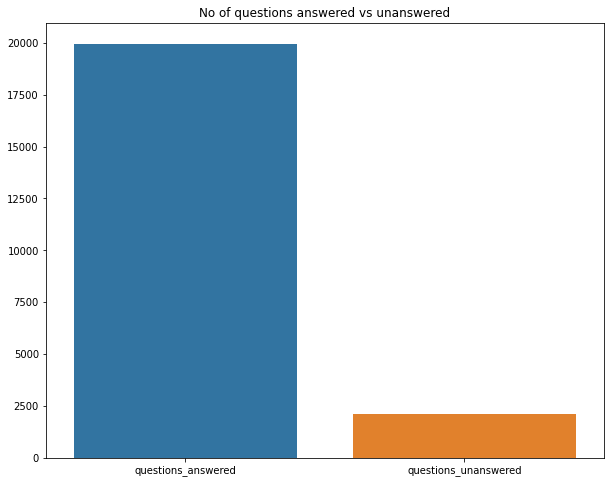

In [20]:
plt.figure(figsize=(10,8))
plt.title("No of questions answered vs unanswered")
plot = sns.barplot(
    x=list(qa_dict.keys()), y=list(qa_dict.values()))
# plt.xticks(rotation=90)
plt.show()

Number of questions answered with in 2 hours

Generated time diffrence of questions created date and its corresponding answers creation date then converted the difference to hours and filterd the questions answered with in 2 hours

In [21]:
qa_df['QuesCreationDate'] = pd.to_datetime(qa_df['QuesCreationDate'])
qa_df['AnsCreationDate'] = pd.to_datetime(qa_df['AnsCreationDate'])
ans_qa_df = qa_df.dropna()
ans_qa_df['diff_hr'] = ans_qa_df.apply(
    lambda x: x['AnsCreationDate'] - x['QuesCreationDate'], axis=1)
ans_qa_df['diff_hr'] = ans_qa_df['diff_hr'].astype('timedelta64[h]')
ans_2hr_qa_df = ans_qa_df[ans_qa_df['diff_hr'] <= 2]
answered_within_2_hr = len(ans_2hr_qa_df['Id'].unique())
answered_after_2_hr = questions_answered - len(ans_2hr_qa_df['Id'].unique())
qa_2hr_dict = {
    'answered_within_2_hr': answered_within_2_hr,
    'answered_after_2_hr': answered_after_2_hr}
qa_2hr_dict

{'answered_within_2_hr': 9843, 'answered_after_2_hr': 10115}

Based on the below plot we could able to see almost 50% of the questions are answered within 2 hours

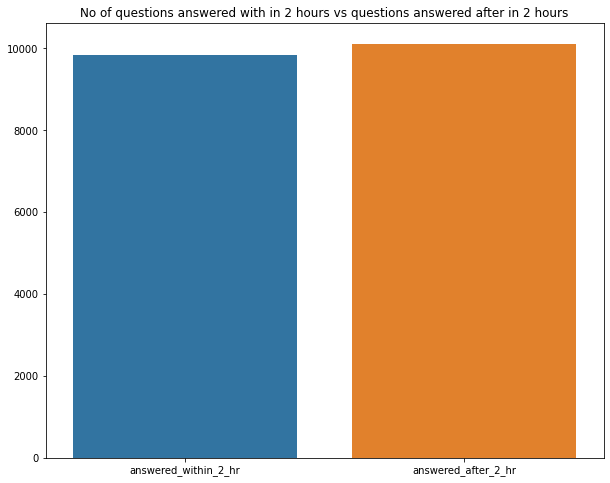

In [22]:
plt.figure(figsize=(10,8))
plt.title("No of questions answered with in 2 hours vs questions answered after in 2 hours")
plot = sns.barplot(
    x=list(qa_2hr_dict.keys()), y=list(qa_2hr_dict.values()))
# plt.xticks(rotation=90)
plt.show()

Day wise number of questions answered within 2 hours

In [23]:
ans_2hr_qa_df['dow'] = ans_2hr_qa_df['QuesCreationDate'].dt.dayofweek
dow_ans_2hr_qa_df = ans_2hr_qa_df.groupby(
    'dow')['Id'].nunique().reset_index().rename(columns={'Id': 'Count'})
dow_ans_2hr_qa_df

,dow,Count
0,0,1700
1,1,1689
2,2,1610
3,3,1530
4,4,1467
5,5,904
6,6,943


Based on the below plot we could able to see more questions are answered quickly(with in 2 hours) in weeekdays compared to the weekends also in weekdays it's gradually decreasing from Monday to Friday

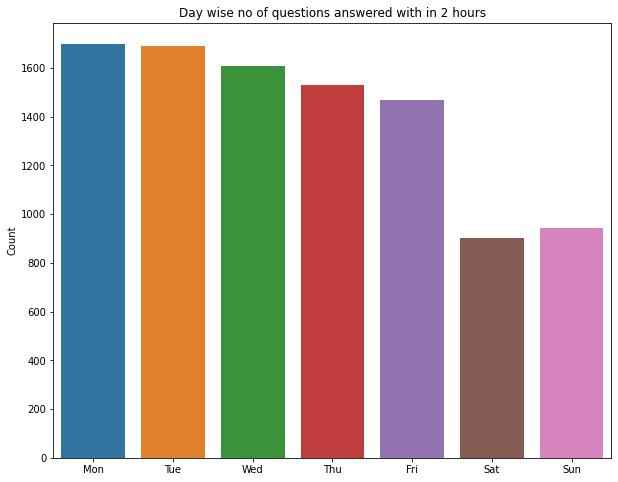

In [24]:
plt.figure(figsize=(10,8))
plt.title("Day wise no of questions answered with in 2 hours")
plot = sns.barplot(
    x=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    y=dow_ans_2hr_qa_df['Count'])
# plt.xticks(rotation=90)
plt.show()

**Cleaning the data to plot country wise users count**

Considered locations with user count more than 10 and cleaned the locations to plot them. 

Note: As we are interested to see which country has more users

In [25]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['name'] = world['name'].str.upper()

In [26]:
user_location_cnt_map = users_df['Location'].dropna().value_counts()[
    users_df['Location'].value_counts().dropna() > 10].to_dict()

In [27]:
cleaned_user_location_cnt_map = {}
for k, v in user_location_cnt_map.items():
  val = k.split(' ')[-1]
  if val in [
      'States', 'USA', 'California', 'CA', 'WA', 'IL', 'Texas', 'NY',
       'MA', 'TX', 'PA', 'GA', 'OR', 'York', 'Jersey', 'CO', 'Florida',
       'Utah', 'Michigan', 'MN', 'FL', 'Ohio', 'Massachusetts', 'Maryland',
       'Connecticut', 'Minnesota', 'OH', 'Carolina', 'DC', 'Francisco',
       'US', 'NC', 'MD', 'Virginia', 'Pennsylvania', 'Illinois', 'Arizona',
       'AZ', 'MO', 'Colorado', 'Oregon', 'Wisconsin', 'NYC', 'WI', 'Kansas',
       'Iowa', 'Indiana']:
    val = "United States of America"
  elif val in ['Kingdom', 'UK', 'England', 'London', 'Scotland']:
    val = "United Kingdom"
  elif val in [
      'Bangalore', 'Delhi', 'Pune', 'Chennai', 'Hyderabad', 'Ahmedabad',
      'Mumbai']:
    val = 'India'
  elif val in ['Zealand']:
    val = 'New Zealand'
  elif val in ['Lanka']:
    val = 'Sri Lanka'
  elif val in ['Emirates']:
    val = 'United Arab Emirates'
  elif val in ['Brasil']:
    val = 'Brazil'
  elif val in ['Paris']:
    val = 'France'
  elif val in ['Toronto']:
    val = 'Canada'
  elif val in ['Istanbul']:
    val = 'Turkey'
  elif val in ['Deutschland', 'Berlin']:
    val = 'Germany'
  elif val in ['xico']:
    val = 'Mexico'
  elif val in ['Republic', 'Prague']:
    val = 'Czechia'
  else:
    val = val
  if val.upper() in cleaned_user_location_cnt_map:
    v += cleaned_user_location_cnt_map[val.upper()]
  names = [col.lower() for col in world['name'].to_list()]
  if val.lower() in world['name'].str.lower().to_list():
    cleaned_user_location_cnt_map[val.upper()] = v

In [28]:
country_count_df = pd.DataFrame({
    'name': cleaned_user_location_cnt_map.keys(),
     'value': cleaned_user_location_cnt_map.values()})
world = world.merge(country_count_df, on=['name'], how='left')
world['value'] = world['value'].fillna(0)

No of users from US and India is high compared to other countries

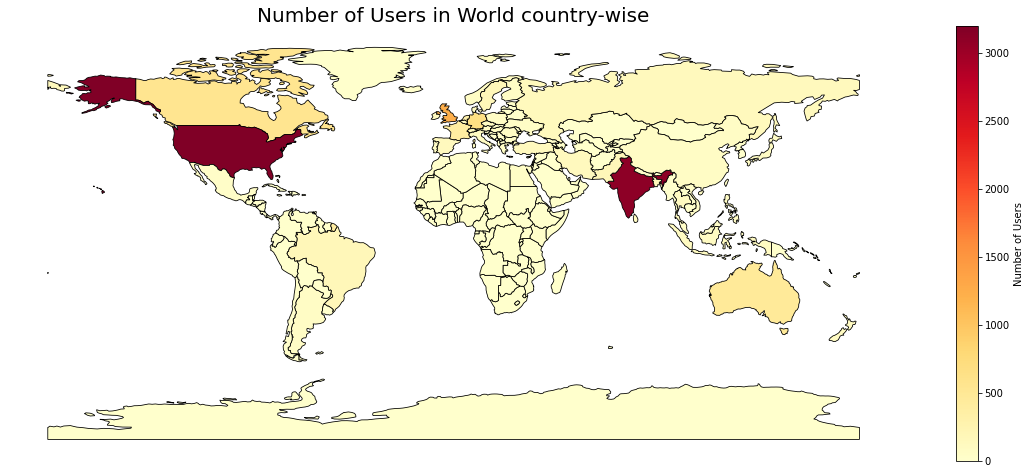

In [29]:
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off')
ax.set_title(
    'Number of Users in World country-wise',
     fontdict={'fontsize': '20', 'fontweight' : '10'})
# Plot the figure
world.plot(column='value',cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0',
           legend=True, markersize=[39.739192, -104.990337],
           legend_kwds={'label': "Number of Users"})
plt.show()

In [30]:
world.sort_values('value', ascending=False)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,value
4,3.282395e+08,North America,UNITED STATES OF AMERICA,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",3199.0
98,1.366418e+09,Asia,INDIA,IND,2868929,"POLYGON ((97.32711 28.26158, 97.40256 27.88254...",3106.0
143,6.683440e+07,Europe,UNITED KINGDOM,GBR,2829108,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",1234.0
121,8.313280e+07,Europe,GERMANY,DEU,3861123,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",665.0
3,3.758926e+07,North America,CANADA,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",558.0
...,...,...,...,...,...,...,...
67,5.380508e+06,Africa,CONGO,COG,12267,"POLYGON ((18.45307 3.50439, 18.39379 2.90044, ...",0.0
68,2.172579e+06,Africa,GABON,GAB,16874,"POLYGON ((11.27645 2.26105, 11.75167 2.32676, ...",0.0
69,1.355986e+06,Africa,EQ. GUINEA,GNQ,11026,"POLYGON ((9.64916 2.28387, 11.27645 2.26105, 1...",0.0
70,1.786103e+07,Africa,ZAMBIA,ZMB,23309,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...",0.0


**Plot to display no of related and duplicate posts**

LinkTypeId type of link

1 = Linked (PostId contains a link to RelatedPostId)

3 = Duplicate (PostId is a duplicate of RelatedPostId)

In the post linked, 25% of the post are duplicates

In [31]:
pl_df = post_links_df.groupby(
    'LinkTypeId')['Id'].count().reset_index().rename({'Id': 'Count'})

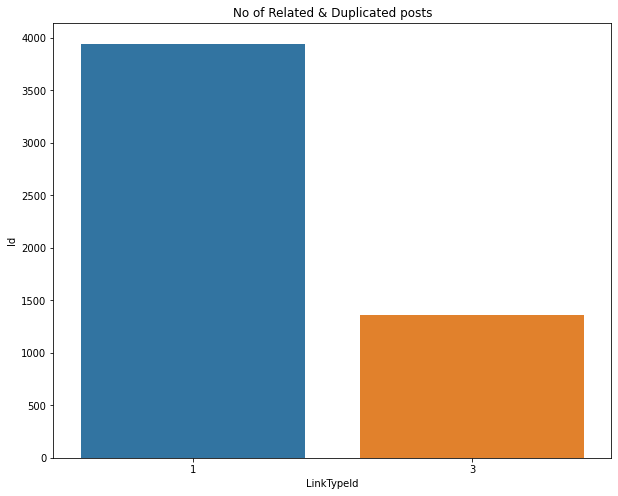

In [32]:
plt.figure(figsize=(10,8))
plt.title("No of Related & Duplicated posts")
plot = sns.barplot(
    x=pl_df['LinkTypeId'], y=pl_df['Id'])
plt.show()

**Numerical columns distribution for posts**

Filtered only the questions and generated overall stats of score, view count and answer count

In [33]:
questions_df = posts_df.query("PostTypeId == 1")
questions_df[['Score', 'ViewCount', 'AnswerCount']].describe().T

,count,mean,std,min,25%,50%,75%,max
Score,22065.0,8.230954,11.092623,-24.0,3.0,5.0,10.0,248.0
ViewCount,22065.0,7540.889735,29029.367814,6.0,402.0,1368.0,4989.0,1522159.0
AnswerCount,22065.0,1.642420,1.447578,0.0,1.0,1.0,2.0,19.0


All these columns are heavily right skewed, ViewCount is large in scale so after applying log transformation view count is closer to normal distribution with mild skewness

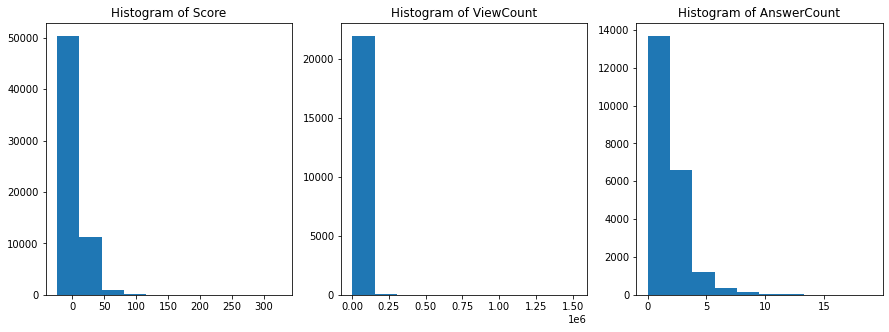

In [34]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Score', 'ViewCount', 'AnswerCount']):
  plt.subplot(1,3,i+1)
  plt.title(f"Histogram of {col}")
  plt.hist(posts_df[col])
plt.show()

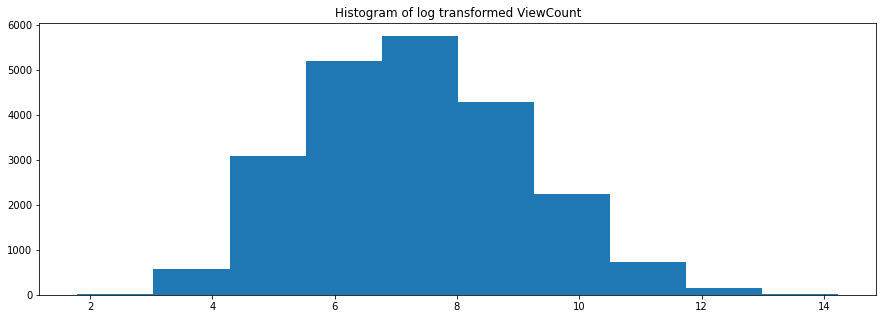

In [35]:
plt.figure(figsize=(15, 5))
plt.title(f"Histogram of log transformed ViewCount")
plt.hist(np.log(posts_df['ViewCount']))
plt.show()

Score, view count and answer count stats by dow(based on question creation date). dow is from 0 to 6 starting from Monday to Sunday

Based on the below plots we could able to see that questions created in weekend have less score, view count and answer count compared to questions created in weekdays

In [36]:
questions_df['CreationDate'] = pd.to_datetime(questions_df['CreationDate'])
questions_df['dow'] = questions_df['CreationDate'].dt.dayofweek
questions_df.groupby('dow')[['Score', 'ViewCount', 'AnswerCount']].describe().T

dow                            0              1              2              3  \
Score       count    3660.000000    3386.000000    3300.000000    3139.000000   
            mean        9.231421       8.874778       8.549091       8.490284   
            std        12.785670      12.135217      11.165880      11.795723   
            min       -24.000000     -14.000000     -13.000000     -15.000000   
            25%         3.000000       3.000000       3.000000       3.000000   
            50%         6.000000       6.000000       5.000000       5.000000   
            75%        11.000000      10.000000      10.000000      10.000000   
            max       248.000000     201.000000     158.000000     223.000000   
ViewCount   count    3660.000000    3386.000000    3300.000000    3139.000000   
            mean     8076.451639    7422.039575    7608.126970    7740.148455   
            std     24385.604281   24815.556126   27196.848415   31051.376760   
            min        26.000000      17.000000      15.000000      18.000000   
            25%       432.000000     453.000000     414.000000     415.000000   
            50%      1505.000000    1541.000000    1391.500000    1398.000000   
            75%      6035.250000    5460.250000    5397.500000    4947.000000   
            max    482600.000000  759588.000000  746024.000000  903487.000000   
AnswerCount count    3660.000000    3386.000000    3300.000000    3139.000000   
            mean        1.723497       1.712640       1.664848       1.637464   
            std         1.531681       1.498143       1.397972       1.479134   
            min         0.000000       0.000000       0.000000       0.000000   
            25%         1.000000       1.000000       1.000000       1.000000   
            50%         1.000000       1.000000       1.000000       1.000000   
            75%         2.000000       2.000000       2.000000       2.000000   
            max        15.000000      16.000000      12.000000      19.000000   

dow                            4             5              6  
Score       count    3141.000000  2.623000e+03    2816.000000  
            mean        7.789876  6.779642e+00       7.338423  
            std         9.255044  8.360048e+00      10.394125  
            min       -10.000000 -1.200000e+01      -9.000000  
            25%         3.000000  2.000000e+00       2.000000  
            50%         5.000000  5.000000e+00       5.000000  
            75%        10.000000  8.000000e+00       9.000000  
            max       114.000000  1.190000e+02     184.000000  
ViewCount   count    3141.000000  2.623000e+03    2816.000000  
            mean     7007.820439  7.615671e+03    7211.747159  
            std     23958.636450  4.495375e+04   25031.124960  
            min        11.000000  1.700000e+01       6.000000  
            25%       403.000000  3.450000e+02     332.750000  
            50%      1352.000000  1.105000e+03    1174.000000  
            75%      4670.000000  4.028500e+03    4145.500000  
            max    529263.000000  1.522159e+06  523144.000000  
AnswerCount count    3141.000000  2.623000e+03    2816.000000  
            mean        1.663801  1.521540e+00       1.520597  
            std         1.447486  1.374905e+00       1.343467  
            min         0.000000  0.000000e+00       0.000000  
            25%         1.000000  1.000000e+00       1.000000  
            50%         1.000000  1.000000e+00       1.000000  
            75%         2.000000  2.000000e+00       2.000000  
            max        14.000000  1.800000e+01      16.000000

**Task 4**

Draw insightful and interesting conclusions. Do not forget to reflect on the potential data privacy
and ethics issues that arise during the data analysis process.

Most common used words in the question title is movie, character, scene, film, end and know. Most common posts are related to plot explanation, character discussion, movie analysis & Marvel Cinematic Universe topics. We could able to find diffferent set of words relavent to each tags(top 4), which can be expanded to all tags and used to build the model to tag the questions based on their title. Approx 10% of the questions are not answered we can take steps to decrease the percentage of unanswered question by promoting those questions to users to earn more badges. Among answered questions approx 50% of the questions are answered with in 2 hours of the question posted. More questions are answered quickly(within 2 hours) in weekdays compared to the weekends also in weekdays it's gradually decreasing from Monday to Friday. No of users from US and India is high compared to the users from other countries. Around 25% of the post linked are duplicates. Overall score, ViewCount and AnswerCount is heavily right skewed, after applying log transformation on viewcount it is kind of closer to normal distribution. Questions created in weekend have less score, view count and answer count compared to questions created in weekdays.

During data collection an ethical approach to data management is to make it clear to the user on what data is being collected and why, our analysis should stick to that and for different analysis we have to get consent from the user before proceeding. Data should be stored securely with appropriate access for the analysis, sensitive informations like location, image, user post related to specific topic should not be shared publically. Applying the analysis should be ethical like in this analysis when are enhancing some features doing the analysis only for particular group is not ethical unless there is justified ethical reason, ideally everyone should be treated equally so when we apply our analysis we should be careful about that. Having that data encoded to not disclose the respondent actual identity will reduce some of the ethical concern.